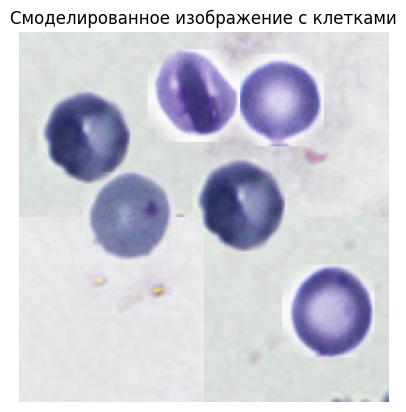

In [20]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def get_image_files(path, extensions=('.jpg', '.png', '.jpeg')):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(extensions)]

def read_images_from_folder(path):
    file_list = get_image_files(path)
    return [cv2.imread(f) for f in file_list if cv2.imread(f) is not None]

def compose_background(patches, size=(256, 256), patch_dim=128, count=4):
    canvas = np.zeros((*size, 3), dtype=np.uint8)
    chosen = random.choices(patches, k=count)
    idx = 0
    for y in range(0, size[0], patch_dim):
        for x in range(0, size[1], patch_dim):
            if idx >= len(chosen):
                break
            patch = cv2.resize(chosen[idx], (patch_dim, patch_dim))
            canvas[y:y+patch_dim, x:x+patch_dim] = patch
            idx += 1
    return canvas

def paste_cells(base_img, cell_imgs, n_cells=6):
    result = base_img.copy()
    for _ in range(n_cells):
        cell = random.choice(cell_imgs)
        cell = cv2.resize(cell, (64, 64))
        h, w = cell.shape[:2]
        x, y = random.randint(0, base_img.shape[0] - h), random.randint(0, base_img.shape[1] - w)

        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (w//2, h//2), min(h, w)//2, 255, -1)
        mask = cv2.GaussianBlur(mask, (21, 21), 0)

        for c in range(3):
            result[y:y+h, x:x+w, c] = (
                result[y:y+h, x:x+w, c] * (1 - mask / 255.0) +
                cell[:, :, c] * (mask / 255.0)
            )
    return result

bg_path = 'content/patches/background'
cell_path = 'content/patches/cells'

bg_patches = read_images_from_folder(bg_path)
cell_patches = read_images_from_folder(cell_path)

background_img = compose_background(bg_patches)
composite_img = paste_cells(background_img, cell_patches)

plt.imshow(cv2.cvtColor(composite_img, cv2.COLOR_BGR2RGB))
plt.title("Смоделированное изображение с клетками")
plt.axis("off")
plt.show()


In [21]:
from skimage.color import rgb2gray

def extract_tamura_features(img):
    gray = rgb2gray(img)
    contrast = np.std(gray)

    coarse = np.mean(gray)

    dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(dx**2 + dy**2)
    directionality = np.std(magnitude)

    return {
        "Контраст": contrast,
        "Крупность": coarse,
        "Направленность": directionality
    }

features = extract_tamura_features(composite_img)
print("Признаки Тамура:")
for key, val in features.items():
    print(f"{key}: {val:.4f}")


Признаки Тамура:
Контраст: 0.1831
Крупность: 0.7915
Направленность: 0.2145


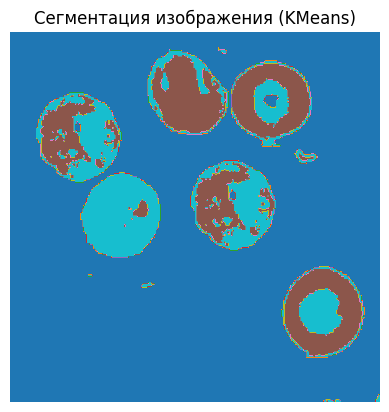

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def preprocess_for_clustering(img):
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    reshaped = lab_img.reshape((-1, 3)).astype(np.float32)
    return reshaped

def cluster_image_kmeans(img, n_clusters=3):
    pixels = preprocess_for_clustering(img)
    scaler = StandardScaler()
    pixels_scaled = scaler.fit_transform(pixels)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels_scaled)

    clustered = labels.reshape(img.shape[:2])
    return clustered, kmeans

segmented_map, kmeans_model = cluster_image_kmeans(composite_img)

plt.imshow(segmented_map, cmap='tab10')
plt.title("Сегментация изображения (KMeans)")
plt.axis("off")
plt.show()


In [23]:
import scipy.ndimage as ndi
from skimage import measure

def analyze_segments(label_map):
    results = []
    unique_labels = np.unique(label_map)

    for label_id in unique_labels:
        mask = (label_map == label_id).astype(np.uint8)

        area = np.sum(mask)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours)

        if area > 0:
            compactness = (perimeter ** 2) / (4 * np.pi * area)
        else:
            compactness = 0

        results.append({
            'Класс': int(label_id),
            'Площадь': area,
            'Периметр': perimeter,
            'Компактность': compactness
        })

    return results

segment_stats = analyze_segments(segmented_map)

for seg in segment_stats:
    print(f"Сегмент {seg['Класс']}: Площадь = {seg['Площадь']}, Периметр = {seg['Периметр']:.2f}, Компактность = {seg['Компактность']:.2f}")


Сегмент 0: Площадь = 49927, Периметр = 1022.14, Компактность = 1.67
Сегмент 1: Площадь = 7694, Периметр = 1408.91, Компактность = 20.53
Сегмент 2: Площадь = 7915, Периметр = 1826.35, Компактность = 33.54


C:\Users\mrgos\AppData\Local\Temp\ipykernel_29492\1789017111.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Класс", y="Площадь", data=df_stats, palette="tab10")
C:\Users\mrgos\AppData\Local\Temp\ipykernel_29492\1789017111.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Класс", y="Периметр", data=df_stats, palette="tab10")
C:\Users\mrgos\AppData\Local\Temp\ipykernel_29492\1789017111.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Класс", y="Компактность", data=df_stats, palette="tab10")


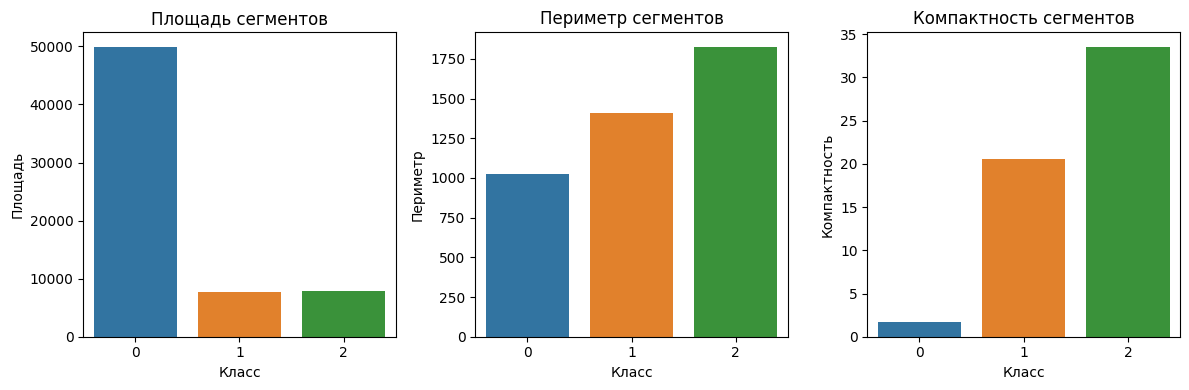

In [24]:
import seaborn as sns
import pandas as pd

df_stats = pd.DataFrame(segment_stats)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.barplot(x="Класс", y="Площадь", data=df_stats, palette="tab10")
plt.title("Площадь сегментов")

plt.subplot(1, 3, 2)
sns.barplot(x="Класс", y="Периметр", data=df_stats, palette="tab10")
plt.title("Периметр сегментов")

plt.subplot(1, 3, 3)
sns.barplot(x="Класс", y="Компактность", data=df_stats, palette="tab10")
plt.title("Компактность сегментов")

plt.tight_layout()
plt.show()


In [25]:
def interpret_segments(stats, area_threshold=500, compactness_threshold=3.0):
    interpretation = []

    for seg in stats:
        if seg['Площадь'] < area_threshold:
            label = "Шум/фон"
        elif seg['Компактность'] < compactness_threshold:
            label = "Фоновая структура"
        else:
            label = "Объект (возможно клетка)"
        interpretation.append({
            'Сегмент': seg['Класс'],
            'Тип': label
        })

    return pd.DataFrame(interpretation)

interp_df = interpret_segments(segment_stats)

print(interp_df)


   Сегмент                       Тип
0        0         Фоновая структура
1        1  Объект (возможно клетка)
2        2  Объект (возможно клетка)


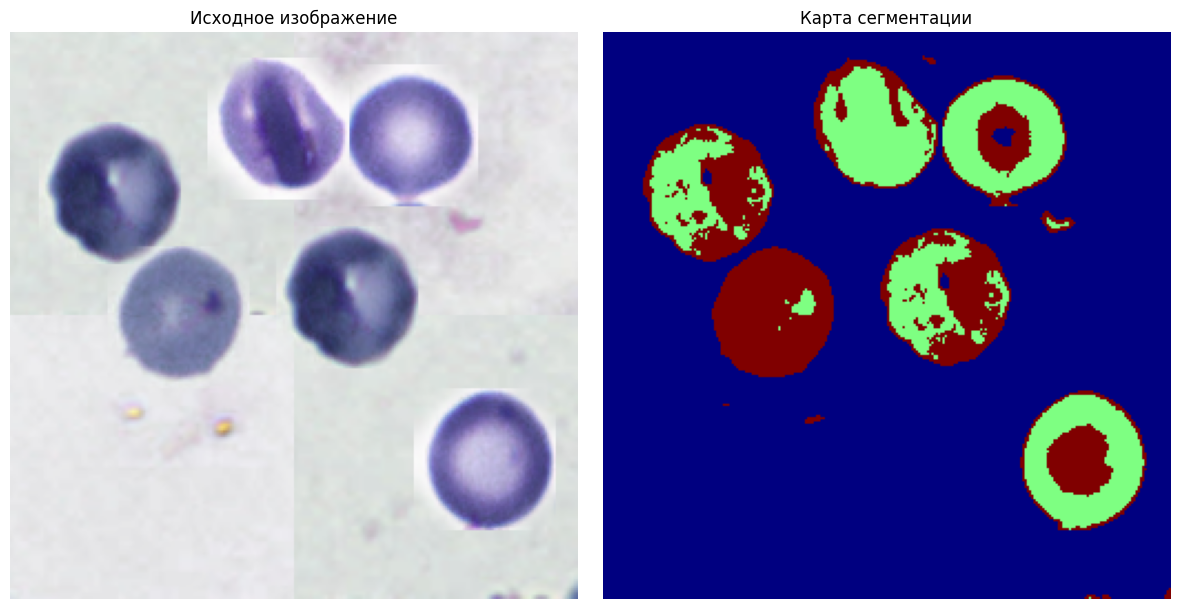

In [26]:
def save_and_display_results(original_img, segmented_map, segment_stats, interpretation_df):
    seg_map_img = (segmented_map / segmented_map.max() * 255).astype(np.uint8)
    seg_map_color = cv2.applyColorMap(seg_map_img, cv2.COLORMAP_JET)

    cv2.imwrite("segmentation_map_gray.png", seg_map_img)
    cv2.imwrite("segmentation_map_color.png", seg_map_color)

    stats_df = pd.DataFrame(segment_stats)
    stats_df.to_csv("segment_stats.csv", index=False)
    interpretation_df.to_csv("segment_interpretation.csv", index=False)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Исходное изображение")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(seg_map_color, cv2.COLOR_BGR2RGB))
    plt.title("Карта сегментации")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()


save_and_display_results(composite_img, segmented_map, segment_stats, interp_df)
